JM: 20 Nov 2023

Test notebook using `xnemogcm` (leveraging `xgcm`) on the UNAGI configuration.

usage log:

* breaks on loading, `combine_attrs keyword not found` (probably because my version of xarray is too old [0.16.1]...)
  * `xarray 0.20.1` certainly seems to work
  * may want to enforce a minimal requirement in versions
* warnings about not finding `eccodes`
  * did `conda install -c conda-forge eccodes`
* complains about file provided not with `_grid_X` suffix
  * swap from `surf_T` to `grid_T` file opens it fine
  * `the global attribute 'description' of each individual file must be 'ocean X grid variables' with X in ['T', 'U', ...]` from `nemo.py`
  * override descriptor would work (e.g. `test.attrs["description"] = "ocean T grid variables"`), consider a pre-process note to do this
* `get_metrics` does not load the `e3X_0` variables for whatever reason
  * by default it tries to load `e3X` but not `e3X_0`, can use `xnemogcm.metrics.compute_missing_metrics` to do something (but make sure `xgcm` is installed)? probably not since it is computing other e3s from e3t directly, and it is still not detecting it in `get_metric` for some reason
  * surely we want to load the _static_ metric files, and then over-ride it with the time-varying ones if anything...
  * could of course just add it in, since `get_metric` generates a dictionary
* d/dx of T grid variable will be U grid, want to imbue it with a `gphi/lamu`?

In [1]:
# usual loading

import matplotlib.pyplot as plt
import numpy as np

# extra loading
from pathlib import Path
from xnemogcm import open_nemo_and_domain_cfg, get_metrics
from xnemogcm.metrics import compute_missing_metrics
import xgcm
import xarray as xr

In [2]:
# try opening
data_dir = "/home/jclmak/data/NEMO_data/UNAGI/EXP_R025/"

# can specify a list (or generate a list via a wildcard) and it will try and open things
# can specify just a directory and it will try and open stuff in general

ds = open_nemo_and_domain_cfg(
    nemo_files= [data_dir + "split_100km/alp0060_lam80/tau100x/OUTPUTS/UNAGI_10y_08010101_08101230_grid_T.nc"],
#     nemo_files= ["./UNAGI_1y_08010101_08101230_surf_T_mod.nc"],
    domcfg_files=[data_dir + "mesh_mask.nc"]
)

In [4]:
ds

<xarray.Dataset>
Dimensions:               (z_c: 30, axis_nbounds: 2, t: 1, y_c: 98, x_c: 360, x_f: 360, y_f: 98, z_f: 30)
Coordinates: (12/20)
  * z_c                   (z_c) int64 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
    time_centered         (t) object dask.array<chunksize=(1,), meta=np.ndarray>
  * t                     (t) object 0806-01-01 00:00:00
  * x_c                   (x_c) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * y_c                   (y_c) int64 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    gdept_1d              (z_c) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    ...                    ...
    gphif                 (y_f, x_f) float64 dask.array<chunksize=(98, 360), meta=np.ndarray>
    gdepw_1d              (z_f) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    gdepw_0               (z_f, y_c, x_c) float64 dask.array<chunksize=(30, 98, 360), meta=np.ndarray>
  * x_f                   (x_f) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * y_f                   (y_f) float64 0.5 1.5 2.5 3.5 ... 94.5 95.5 96.5 97.5
  * z_f                   (z_f) float64 -0.5 0.5 1.5 2.5 ... 25.5 26.5 27.5 28.5
Dimensions without coordinates: axis_nbounds
Data variables: (12/58)
    deptht_bounds         (z_c, axis_nbounds) float32 dask.array<chunksize=(30, 2), meta=np.ndarray>
    time_centered_bounds  (t, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    t_bounds              (t, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    toce                  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 30, 98, 360), meta=np.ndarray>
    soce                  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 30, 98, 360), meta=np.ndarray>
    sst                   (t, y_c, x_c) float32 dask.array<chunksize=(1, 98, 360), meta=np.ndarray>
    ...                    ...
    e3u_0                 (z_c, y_c, x_f) float64 dask.array<chunksize=(30, 98, 360), meta=np.ndarray>
    e3v_0                 (z_c, y_f, x_c) float64 dask.array<chunksize=(30, 98, 360), meta=np.ndarray>
    e3f_0                 (z_c, y_f, x_f) float64 dask.array<chunksize=(30, 98, 360), meta=np.ndarray>
    e3w_0                 (z_f, y_c, x_c) float64 dask.array<chunksize=(30, 98, 360), meta=np.ndarray>
    e3uw_0                (z_f, y_c, x_f) float64 dask.array<chunksize=(30, 98, 360), meta=np.ndarray>
    e3vw_0                (z_f, y_f, x_c) float64 dask.array<chunksize=(30, 98, 360), meta=np.ndarray>
Attributes:
    name:         NEMO dataset
    description:  Ocean grid variables, set on the proper positions
    title:        Ocean grid variables
    Conventions:  CF-1.6
    timeStamp:    2023-Sep-30 05:29:45 GMT
    uuid:         37f92bb3-ae89-450b-a302-09cb031609a6
    TimeStamp:    10/07/2022 21:13:13 +0800

In [78]:
Static_e3 = True
metrics_dict = get_metrics(ds)
print(metrics_dict)
if Static_e3:
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']
print(metrics_dict)

# tidy up of metrics: EW peridicity seems to screw up the metrics at the perodic points in NEMO4.0 leading to
#                     divide by zeros, just add it back in

for points in ["t", "u", "v", "f"]:
    ds[f"e1{points}"][:,  0] = ds[f"e1{points}"][:,  1].values
    ds[f"e1{points}"][:, -1] = ds[f"e1{points}"][:,  0].values
    ds[f"e2{points}"][:,  0] = ds[f"e2{points}"][:,  1].values
    ds[f"e2{points}"][:, -1] = ds[f"e2{points}"][:,  0].values
    
    ds[f"e3{points}_0"][:,  0] = ds[f"e3{points}_0"][:,  1].values
    ds[f"e3{points}_0"][:, -1] = ds[f"e3{points}_0"][:,  0].values

{('X',): ['e1t', 'e1u', 'e1v', 'e1f'], ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], ('Z',): []}
{('X',): ['e1t', 'e1u', 'e1v', 'e1f'], ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']}


In [10]:
grid = xgcm.Grid(ds, metrics=get_metrics(ds), periodic=["X"])  # specify periodicity with a list
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center
T Axis (not periodic, boundary=None):
  * center   t
X Axis (periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_f --> center

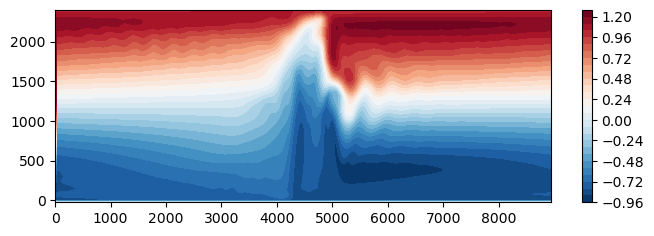

In [79]:
# sample plot (just use ssh)
# periodicity in EW, need to chop 1 off from the end for plotting

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(ds.glamt[:, :-1], ds.gphit[:, :-1], ds.ssh[0, :, :-1], 31, cmap="RdBu_r") 
plt.colorbar(cs)

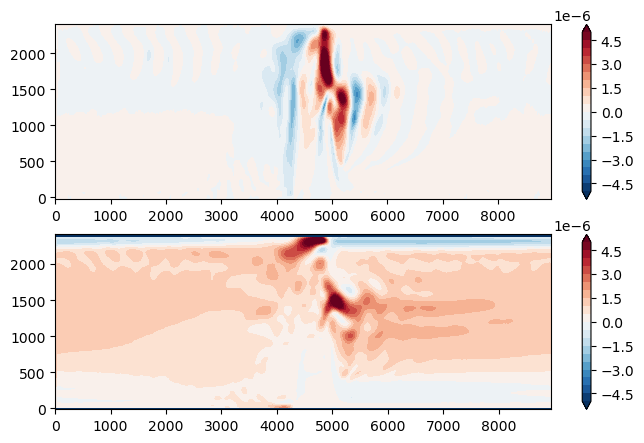

In [94]:
# dervatives (of a T-grid variable, which will be a U and V grid accordingly)
# ?? want to do extra imbuements (of gphi[uv] etc.)?

ssh_x = grid.derivative(ds.ssh, axis='X', boundary='fill', fill_value=0)  # U grid
ssh_y = grid.derivative(ds.ssh, axis='Y', boundary='fill', fill_value=0)  # V grid

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(2, 1, 1)
cs = ax.contourf(ds.glamu[:, :-1], ds.gphiu[:, :-1], ssh_x[0, :, :-1], 
                 levels=np.linspace(-5e-6, 5e-6, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

ax = plt.subplot(2, 1, 2)
cs = ax.contourf(ds.glamv[:, :-1], ds.gphiv[:, :-1], ssh_y[0, :, :-1],
                 levels=np.linspace(-5e-6, 5e-6, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

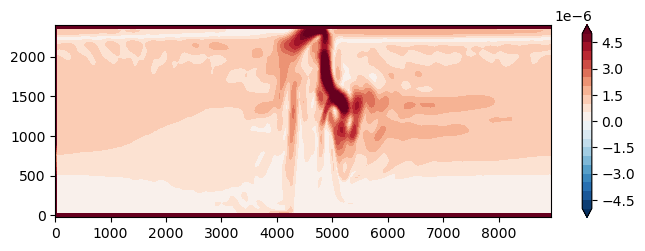

In [107]:
# something a bit more sophisticated: |\grad h| = np.sqrt((dh/dx)^2 + (dh/dy)^2)
#    U and V grid variables want to be placed on T grid
# default of (ssh_x)**2 + (ssh_y)** 2 doesn't work and generates a 5 dim object (axis joining accordingly)

# interp onto T grid first and then do the thing

grad_h = np.sqrt(grid.interp(ssh_x, axis="X", to="center")**2 + grid.interp(ssh_y, axis="Y", to="center")**2)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(ds.glamt[:, :-1], ds.gphit[:, :-1], grad_h[0, :, :-1], 
                 levels=np.linspace(-5e-6, 5e-6, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

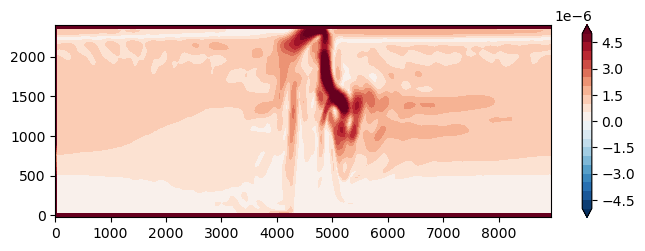

In [127]:
# test wrap into a subroutine

def mod_ssh(grid, h):
    "Computes |grad h| = sqrt(h_x**2 + h_y**2)"
    
    h_x = grid.derivative(h, axis='X', boundary='fill', fill_value=0)
    h_y = grid.derivative(h, axis='Y', boundary='fill', fill_value=0)
    
    return np.sqrt(grid.interp(h_x, axis="X", to="center")**2 + grid.interp(h_y, axis="Y", to="center")**2)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(ds.glamt[:, :-1], ds.gphit[:, :-1], mod_ssh(grid, ds.ssh[0, :, :])[:, :-1],
                 levels=np.linspace(-5e-6, 5e-6, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

In [2]:
# something a bit more sophisticated: relative vorticity

# data is not in a form xnemogcm directly understands, so needs some pre-processing

data_dir = "/home/jclmak/data/NEMO_data/UNAGI/EXP_R025/"

for points in ["U", "V"]:
    test = xr.open_dataset(data_dir + 
              f"split_100km/alp0060_lam80/tau100x/OUTPUTS/UNAGI_1y_08010101_08101230_surf_{points}.nc")
    test.attrs.get("description", "")
    test.attrs["description"] = f"ocean {points} grid variables"
    test.to_netcdf(f"./UNAGI_1y_08010101_08101230_surf_{points}.nc")

In [3]:
# open the massaged data that xnemogcm should understand

ds = open_nemo_and_domain_cfg(
    nemo_files= ["./UNAGI_1y_08010101_08101230_surf_U.nc", "./UNAGI_1y_08010101_08101230_surf_V.nc"],
    domcfg_files=[data_dir + "mesh_mask.nc"]
)

Static_e3 = True
metrics_dict = get_metrics(ds)
print(metrics_dict)
if Static_e3:
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']
print(metrics_dict)

# tidy up of metrics: EW peridicity seems to screw up the metrics at the perodic points in NEMO4.0 leading to
#                     divide by zeros, just add it back in

for points in ["t", "u", "v", "f"]:
    ds[f"e1{points}"][:,  0] = ds[f"e1{points}"][:,  1].values
    ds[f"e1{points}"][:, -1] = ds[f"e1{points}"][:,  0].values
    ds[f"e2{points}"][:,  0] = ds[f"e2{points}"][:,  1].values
    ds[f"e2{points}"][:, -1] = ds[f"e2{points}"][:,  0].values
    
    ds[f"e3{points}_0"][:,  0] = ds[f"e3{points}_0"][:,  1].values
    ds[f"e3{points}_0"][:, -1] = ds[f"e3{points}_0"][:,  0].values
    
grid = xgcm.Grid(ds, metrics=get_metrics(ds), periodic=["X"])  # specify periodicity with a list

{('X',): ['e1t', 'e1u', 'e1v', 'e1f'], ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], ('Z',): []}
{('X',): ['e1t', 'e1u', 'e1v', 'e1f'], ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']}


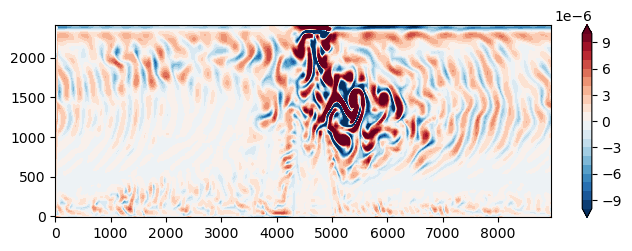

In [16]:
def cdfcurl_crude(grid, ds, u, v, jt=0):
    "Computes the 2d curl at a fixed horizontal level (e.g. vertical component of relative vorticity)"
    
    v_x = grid.derivative(v[jt, :, :], axis='X', boundary='fill', fill_value=0)  # F point
    u_y = grid.derivative(u[jt, :, :], axis='Y', boundary='fill', fill_value=0)  # F point
    
    return (v_x - u_y) * ds.fmask[0, :, :]

xi = cdfcurl_crude(grid, ds, ds.ssu_inst, ds.ssv_inst, jt=2)  # there are NaN's in the data for some reason...?

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(ds.glamf[:, :-1], ds.gphif[:, :-1], xi[:, :-1],
                 levels=np.linspace(-1e-5, 1e-5, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

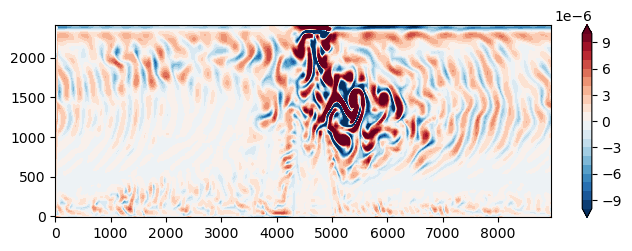

In [35]:
def cdfcurl(grid, ds, u, v, jt=0, **bd):
    """Computes the 2d curl at a fixed horizontal level (e.g. vertical component of relative vorticity),
       but in a NEMO compilant way
    """
    
    curl_uv  = (  grid.diff(v[jt, :, :] * ds.e2v, "X", **bd) 
                - grid.diff(u[jt, :, :] * ds.e1u, "Y", **bd) 
               ) / (ds.e1f * ds.e2f)
    curl_uv *= ds.fmask[0, :, :]
    
    return curl_uv

bd = {'boundary':'fill', 'fill_value':0}
# there are NaN's in the data for some reason...?
xi = cdfcurl(grid, ds, ds.ssu_inst, ds.ssv_inst, jt=2, **bd)  

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(ds.glamf[:, :-1], ds.gphif[:, :-1], xi[:, :-1],
                 levels=np.linspace(-1e-5, 1e-5, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

In [37]:
# MOC
data_dir = "/home/jclmak/data/NEMO_data/UNAGI/EXP_R025/"

ds = open_nemo_and_domain_cfg(
    nemo_files= [data_dir + "split_100km/alp0060_lam80/tau100x/OUTPUTS/UNAGI_10y_08010101_08101230_grid_V.nc"],
    domcfg_files=[data_dir + "mesh_mask.nc"]
)

Static_e3 = True
metrics_dict = get_metrics(ds)
print(metrics_dict)
if Static_e3:
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']
print(metrics_dict)

# tidy up of metrics: EW peridicity seems to screw up the metrics at the perodic points in NEMO4.0 leading to
#                     divide by zeros, just add it back in

for points in ["t", "u", "v", "f"]:
    ds[f"e1{points}"][:,  0] = ds[f"e1{points}"][:,  1].values
    ds[f"e1{points}"][:, -1] = ds[f"e1{points}"][:,  0].values
    ds[f"e2{points}"][:,  0] = ds[f"e2{points}"][:,  1].values
    ds[f"e2{points}"][:, -1] = ds[f"e2{points}"][:,  0].values
    
    ds[f"e3{points}_0"][:,  0] = ds[f"e3{points}_0"][:,  1].values
    ds[f"e3{points}_0"][:, -1] = ds[f"e3{points}_0"][:,  0].values
    
grid = xgcm.Grid(ds, metrics=get_metrics(ds), periodic=["X"])  # specify periodicity with a list

{('X',): ['e1t', 'e1u', 'e1v', 'e1f'], ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], ('Z',): []}
{('X',): ['e1t', 'e1u', 'e1v', 'e1f'], ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']}


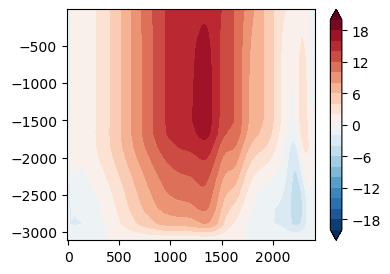

In [93]:
def cdfmoc(grid, ds, v, jt=0, **bd):
    """Computes the meridional overturning circulation in depth co-ordinates,
       in a way consistent with CDFTOOLS/cdfmoc
    """
    
    # input is (z, y, x), grid_V, units of m s-1

    # integrate in i
    moc = (v * ds.e1v * ds.e3v_0).sum(dim="x_c")    # (z, y   ), grid_V, units of m3 s-1

    # cumulative sum in k from TOP
    moc = grid.cumsum(moc, axis="Z", **bd) / 1e6    # sum in Z puts things on z_f, units of Sv
    
    # remove the total integral (the last entry)
    return moc - moc.isel({"z_f" : -1})

moc = cdfmoc(grid, ds, ds.voce[0, :, :, :])

# problem near the periodic boundary outputs at 0 and -1, just don't use it for now...
# great big deep reaching (unphysical) Deacon cell, as expected

fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
cs = ax.contourf(ds.gphiv[:, 1], -ds.gdept_1d, moc,
                 levels=np.linspace(-20, 20, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

In [6]:
# pre-process into a form xnemogcm can understand
test = xr.open_dataset(data_dir + "split_100km/alp0060_lam80/tau100x/OUTPUTS/UNAGI_1y_08010101_08101230_surf_T.nc")
test.attrs.get("description", "")
test.attrs["description"] = "ocean T grid variables"
test.to_netcdf("./UNAGI_1y_08010101_08101230_surf_T_mod.nc")

'surface U grid variables'